In [3]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [28]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester
from convlstm import BConvLSTM

Load specific variables for each dataset

In [15]:
version = 1
data_path = '/content/drive/My Drive/Colab Notebooks/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
param = {'layer_size': 3, 'kernel_size': 5, 'hidden_dim': 32}

In [16]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [17]:
print(torch.version.cuda)

10.1


Seed

In [18]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [19]:
def init_seed(seed):
    np.random.seed(seed)

In [20]:
init_seed = init_seed(seed)

Hyperparameters

In [26]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.8
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']

Loading the dataset

In [22]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [23]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split, data_type='Reconstruction')
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [24]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("Removed : ", train_data.removed.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("Removed : ", val_data.removed.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)
print("Removed : ", test_data.removed.shape)

-----Train-----
X :  torch.Size([8376, 1, 10, 50, 50])
Y :  torch.Size([8376, 1, 10, 50, 50])
Removed :  torch.Size([8376])
-----Val-----
X :  torch.Size([2792, 1, 10, 50, 50])
Y :  torch.Size([2792, 1, 10, 50, 50])
Removed :  torch.Size([2792])
-----Test-----
X :  torch.Size([2792, 1, 10, 50, 50])
Y :  torch.Size([2792, 1, 10, 50, 50])
Removed :  torch.Size([2792])


In [25]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [35]:
class STConvLSTM(nn.Module):
    
    def __init__(self, layer_size, kernel_size, input_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.conv_lstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        input_dim=1
        for i in range(layer_size):
            self.conv_lstm_layer.append(BConvLSTM(input_size=input_size, input_dim=input_dim, hidden_dim=hidden_dim,
                                                kernel_size=(kernel_size, kernel_size),
                                                 num_layers=1, batch_first=True, bias=False, return_all_layers=True))
            self.relu_layers.append(nn.ReLU())
            self.bn_layers.append(nn.BatchNorm3d(hidden_dim))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim
            
        self.final_conv = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, bn, drop in zip(self.conv_lstm_layer, self.relu_layers, self.bn_layers, self.dropout_layers):
            x_rev = torch.flip(x, [2])
            x = convlstm(x, x_rev)
            x = bn(x)
            x = relu(x)
            x = drop(x)
            
        out = self.final_conv(x)
        return out

In [36]:
class WeightedRMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            cumulative_loss += ((yhat[i,:,removed[i],:,:] - y[i,:,removed[i],:,:])**2).mean()
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)

In [37]:
model = STConvLSTM(layer_size, kernel_size, input_size=(train_data.x.shape[3], train_data.x.shape[4]), hidden_dim=hidden_dim).to(device)
criterion = WeightedRMSELoss()
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)
model

STConvLSTM(
  (conv_lstm_layer): ModuleList(
    (0): BConvLSTM(
      (forward_net): ConvLSTM(
        (cell_list): ModuleList(
          (0): ConvLSTMCell(
            (conv): Conv2d(33, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          )
        )
      )
      (backward_net): ConvLSTM(
        (cell_list): ModuleList(
          (0): ConvLSTMCell(
            (conv): Conv2d(33, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          )
        )
      )
    )
    (1): BConvLSTM(
      (forward_net): ConvLSTM(
        (cell_list): ModuleList(
          (0): ConvLSTMCell(
            (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          )
        )
      )
      (backward_net): ConvLSTM(
        (cell_list): ModuleList(
          (0): ConvLSTMCell(
            (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          )
        )
      )
    )
    (2): BCon

Training the model

In [38]:
model_path = os.path.join('../../../models/ConvLSTM' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, cut_output=False, recurrent_model=False, is_reconstruction=True)


In [ ]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 6.305953
Val Avg. Loss: 5.980545
=> Saving a new best


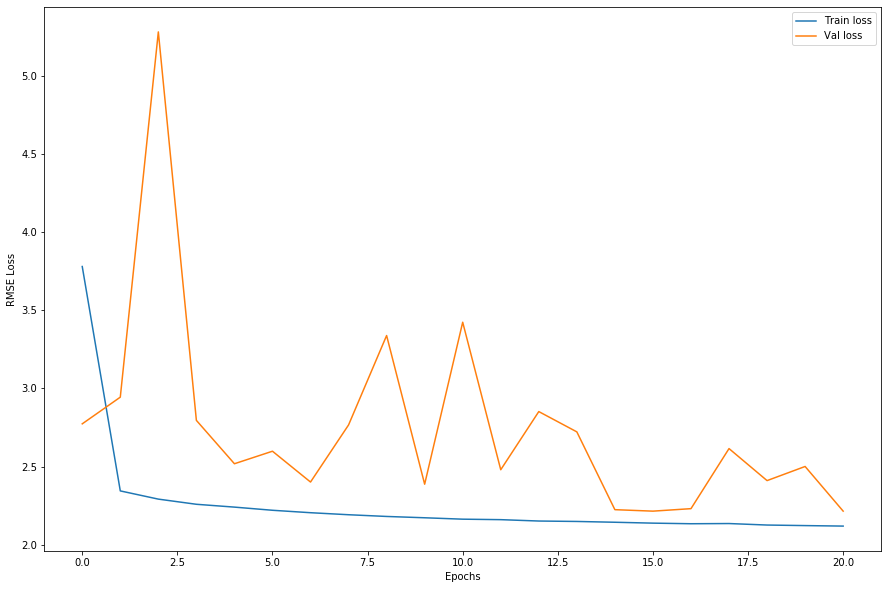

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [ ]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        output = model(x)
        loss = criterion(output, y, removed)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S WeightedRMSELoss: 2.2024


In [ ]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [ ]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

criterion_mae = torch.nn.L1Loss()
criterion_rmse = RMSELoss()
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2 = metrics.r2_score(y_true, y_pred)
    ar2 =  1.0 - ( mse / y_true.var() )
    return r2, ar2

def report_losses(y_true, y_pred):
    mae = criterion_mae(y_true, y_pred)
    rmse = criterion_rmse(y_true, y_pred)
    return mae, rmse

def report_metrics(y_true, y_pred, removed):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0.0
    ar2 = 0.0
    mae = 0.0
    rmse = 0.0
    for i in range(batch):
        v1,v2 = report_r2(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        r2 += v1
        ar2 += v2
        v1, v2 = report_losses(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        mae += v1
        rmse += v2
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    mae = mae/batch
    rmse = rmse/batch
    return mae, rmse, r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('ConvLSTM')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

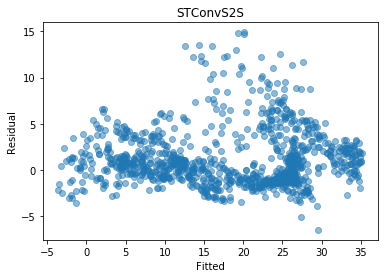

STConvS2S: 2.2369
Explained variance:  0.9389
r2:  0.913
ar2:  0.9217


In [ ]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss_mae = 0.0
batch_test_loss_rmse = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        output = model(x)
        loss_mae, loss_rmse, r2, ar2 = report_metrics(y, output, removed)
        if (i == 0):
            plot_residual_fitted(y[0,0,removed[i],:,:].cpu(), output[0,0,removed[i],:,:].cpu())
        batch_test_loss_mae += loss_mae.detach().item()
        batch_test_loss_rmse += loss_rmse.detach().item()
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss_mae = batch_test_loss_mae/len(test_loader)
test_loss_rmse = batch_test_loss_rmse/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'MAE: {test_loss_mae:.4f}')
print(f'RMSE: {test_loss_rmse:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))